In [1]:
#pip install bstpp

In [ ]:
import bstpp

In [2]:
#!pip install --upgrade scipy jax jaxlib

In [ ]:
from bstpp.main import LGCP_Model, Hawkes_Model,  Point_Process_Model

/usr/local/lib/python3.11/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.5.1 is installed, but it is not compatible with the installed jaxlib version 0.6.0, so it will not be used.
  warnings.warn(


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import numpyro.distributions as dist
from shapely.geometry import box
import seaborn as sns

#**CONFIGURATION**

In [ ]:
EVENTS_PATH = "/content/drive/MyDrive/data1/COVID/london_covid_events.csv"
COVARIATES_PATH = "/content/drive/MyDrive/data1/COVID/london_covid_covariates.csv"
OUTPUT_DIR = "/content/drive/MyDrive/data1/bstpp_ebola_analysis_results/"
FIGURE_DIR = "/content/drive/MyDrive/data1/bstpp_ebola_analysis_results/"
SHAPEFILE_PATH = "/content/drive/MyDrive/data1/COVID/Greater_London_Authority_(GLA).shp"  # Update path if available

MCMC_WARMUP = 100
MCMC_SAMPLES = 400
MCMC_CHAINS = 1

SUBSET_SIZE = 10000

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(FIGURE_DIR, exist_ok=True)

#**LOAD DATA**

In [ ]:
events_df = pd.read_csv(EVENTS_PATH)
events_df = events_df.sample(n=SUBSET_SIZE, random_state=42).sort_values("T").reset_index(drop=True)
#events_df = events_df[events_df["T"] <= 40].copy()

print("Subset events data:")
print(events_df.head())

Subset events data:
         X        Y         T
0 -0.01734  51.4423  0.005073
1 -0.20021  51.4524  0.023703
2 -0.01734  51.4423  0.042762
3 -0.06045  51.5549  0.070094
4 -0.10670  51.5877  0.108171


In [ ]:
events_df['T'].unique()

array([5.07254894e-03, 2.37031549e-02, 4.27615044e-02, ...,
       1.39894264e+02, 1.39904470e+02, 1.39923553e+02])

In [ ]:
len(events_df)

10000

#**EDA - EXPLORATORY DATA ANALYSIS**

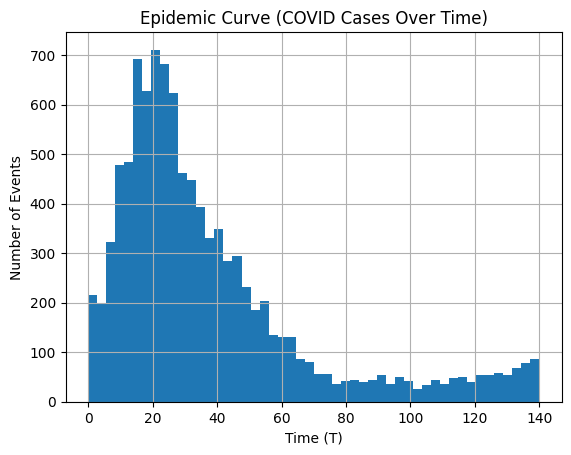

In [ ]:
# Epidemic curve
plt.figure()
events_df["T"].hist(bins=50)
plt.xlabel("Time (T)")
plt.ylabel("Number of Events")
plt.title("Epidemic Curve (COVID Cases Over Time)")
plt.savefig(f"{FIGURE_DIR}/eda_epidemic_curve.png")
plt.show()

# Plot 1: Epidemic Curve (Histogram of events over time)

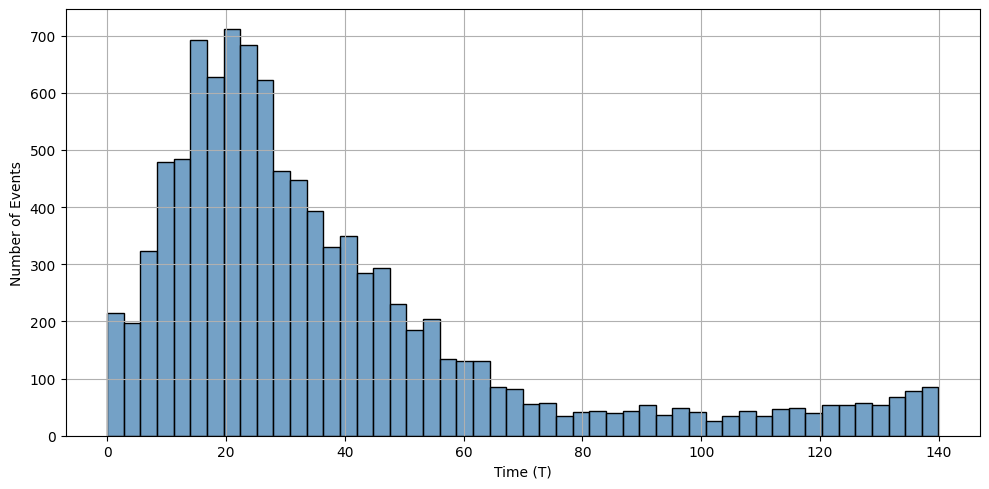

In [ ]:

plt.figure(figsize=(10, 5))
sns.histplot(events_df["T"], bins=50, kde=False, color="steelblue")
#plt.title("Epidemic Curve: Event Counts Over Time")
plt.xlabel("Time (T)")
plt.ylabel("Number of Events")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Cumulative Events Over Time

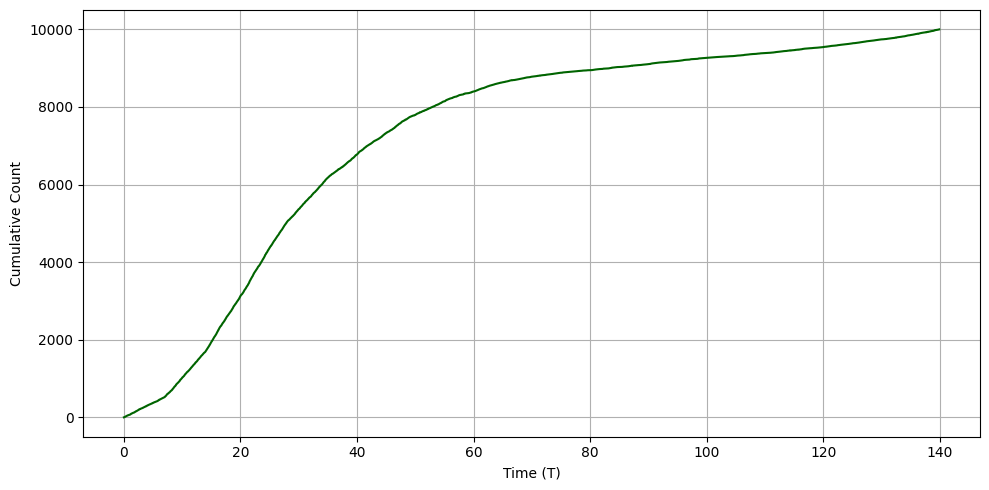

In [ ]:

sorted_times = np.sort(events_df["T"].values)
cumulative_counts = np.arange(1, len(sorted_times) + 1)

plt.figure(figsize=(10, 5))
plt.plot(sorted_times, cumulative_counts, color="darkgreen")
#plt.title("Cumulative Number of Events Over Time")
plt.xlabel("Time (T)")
plt.ylabel("Cumulative Count")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 3: Autocorrelation of event timestamps

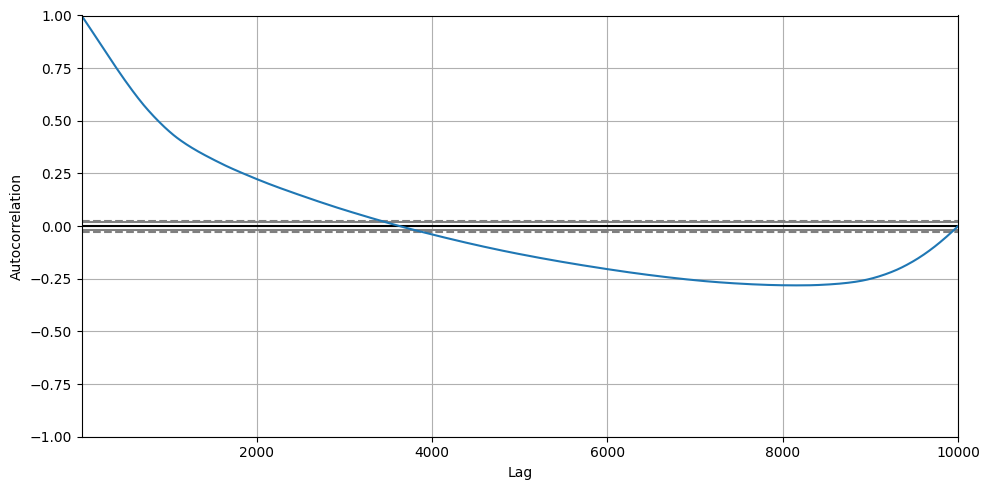

In [ ]:

from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(10, 5))
autocorrelation_plot(events_df["T"].sort_values().reset_index(drop=True))
#plt.title("Autocorrelation of Event Times")
plt.tight_layout()
plt.show()

# Scatter plot of events (X, Y)

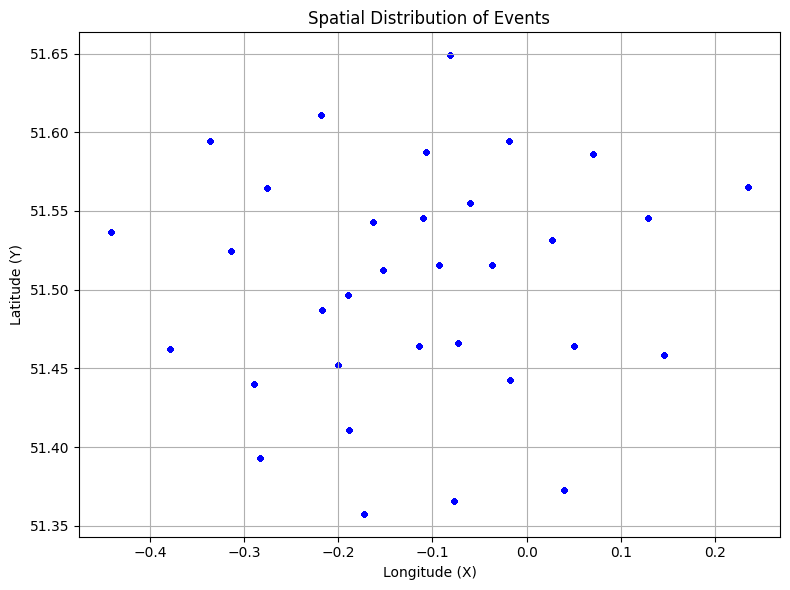

In [ ]:

plt.figure(figsize=(8, 6))
plt.scatter(events_df["X"], events_df["Y"], alpha=0.5, c='blue', s=10)
plt.title("Spatial Distribution of Events")
plt.xlabel("Longitude (X)")
plt.ylabel("Latitude (Y)")
plt.grid(True)
plt.tight_layout()
plt.show()

# KDE (Kernel Density Estimation) for spatial intensity

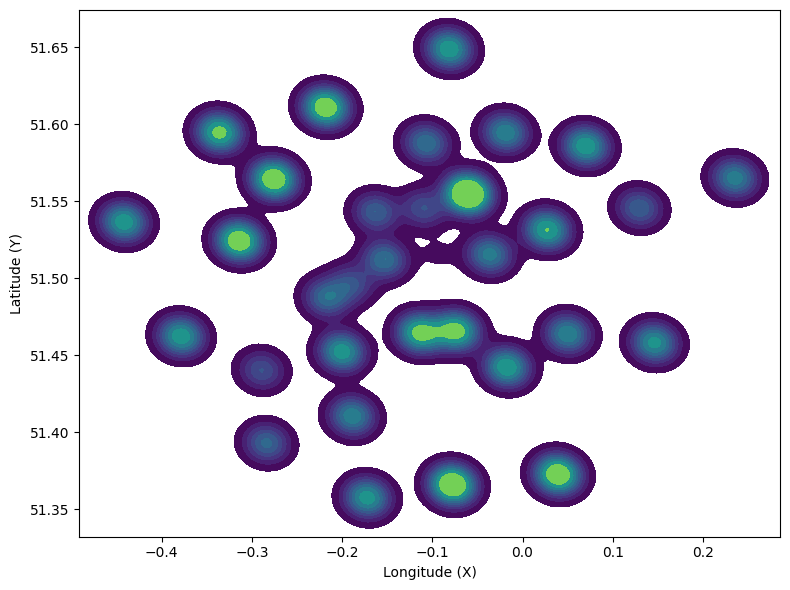

In [ ]:

plt.figure(figsize=(8, 6))
sns.kdeplot(
    x=events_df["X"],
    y=events_df["Y"],
    fill=True,
    cmap="viridis",
    bw_adjust=0.5,
    thresh=0.05
)
#plt.title("Spatial KDE (Intensity Approximation)")
plt.xlabel("Longitude (X)")
plt.ylabel("Latitude (Y)")
plt.tight_layout()
plt.show()

# 2D histogram heatmap

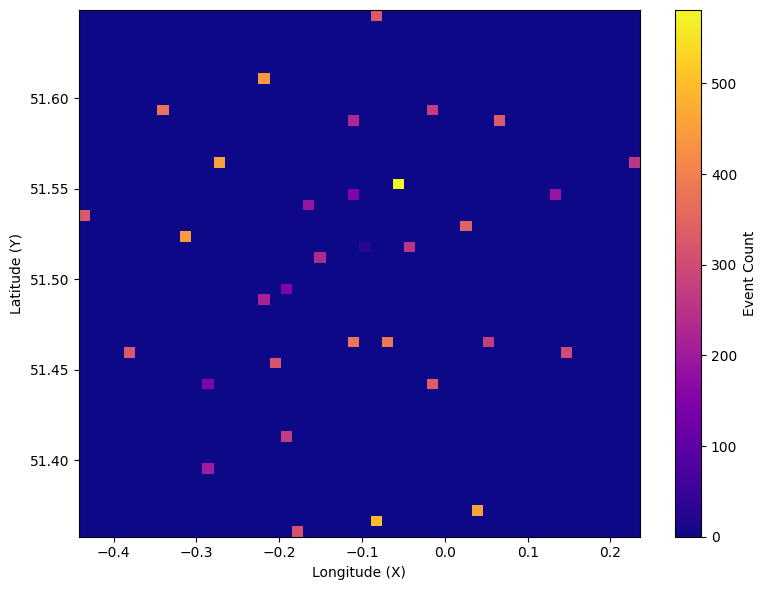

In [ ]:

plt.figure(figsize=(8, 6))
plt.hist2d(events_df["X"], events_df["Y"], bins=50, cmap="plasma")
plt.colorbar(label="Event Count")
#plt.title("2D Histogram Heatmap of Events")
plt.xlabel("Longitude (X)")
plt.ylabel("Latitude (Y)")
plt.tight_layout()
plt.show()

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import os


if SHAPEFILE_PATH and os.path.exists(SHAPEFILE_PATH):
    # Load and fix CRS if needed
    shp = gpd.read_file(SHAPEFILE_PATH)
    if shp.crs is None:
        shp = shp.set_crs("EPSG:27700", allow_override=True)

    # Convert event DataFrame to GeoDataFrame and reproject
    events_gdf = gpd.GeoDataFrame(
        events_df,
        geometry=gpd.points_from_xy(events_df["X"], events_df["Y"]),
        crs="EPSG:4326"
    )
    events_gdf = events_gdf.to_crs(shp.crs)


#Plot COVID Events Over 4 Time Slices

<ipython-input-18-82d44dfbabdd>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("plasma")
<ipython-input-18-82d44dfbabdd>:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.92])


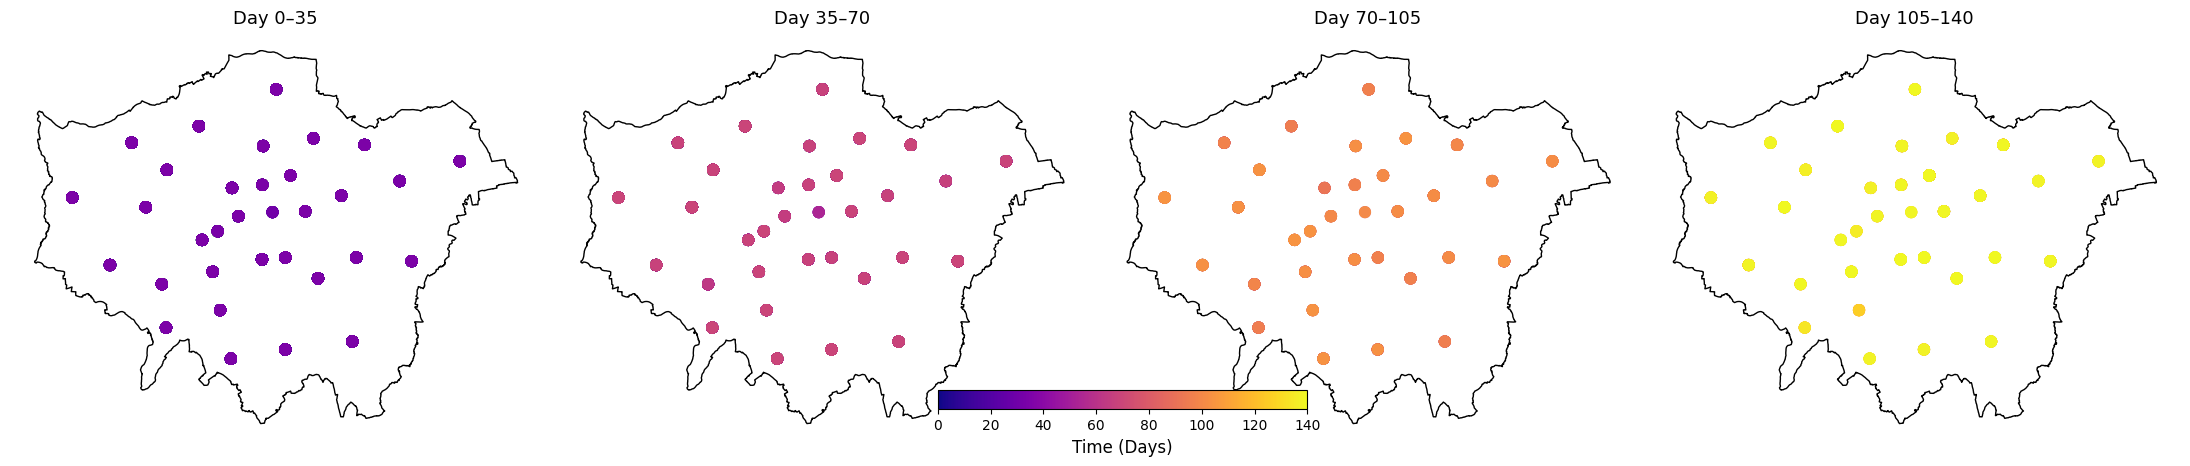

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from matplotlib.colors import Normalize

# === Define time bins and color normalization ===
bins = [0, 35, 70, 105, 140]
norm = Normalize(vmin=0, vmax=140)
cmap = cm.get_cmap("plasma")

# === Create 1-row, 4-column layout ===
fig, axs = plt.subplots(1, 4, figsize=(22, 6), sharex=True, sharey=True)

for i, ax in enumerate(axs):
    t_start, t_end = bins[i], bins[i + 1]
    slice_df = events_gdf[(events_gdf["T"] >= t_start) & (events_gdf["T"] < t_end)]

    shp.plot(ax=ax, color='white', edgecolor='black', linewidth=1)
    slice_df.plot(
        ax=ax,
        column="T",
        cmap=cmap,
        norm=norm,
        markersize=60,
        alpha=0.9,
        legend=False
    )

    ax.set_title(f"Day {t_start}–{t_end}", fontsize=13)
    ax.set_axis_off()

# === Add a shared colorbar ===
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm._A = []
cbar = fig.colorbar(sm, ax=axs, orientation="horizontal", fraction=0.04, pad=0.1)
cbar.set_label("Time (Days)", fontsize=12)

#plt.suptitle("COVID Event Distribution by Time ", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.92])
plt.show()


#Spatial Join of Events to Covariate Polygons

In [ ]:
import geopandas as gpd
from shapely.geometry import box

# === Load covariates as GeoDataFrame ===
covariates_df = pd.read_csv(COVARIATES_PATH)

# Create square polygons around each covariate point (grid cell)
grid_size = 2000  # in meters
covariates_gdf = gpd.GeoDataFrame(
    covariates_df,
    geometry=gpd.points_from_xy(covariates_df["X"], covariates_df["Y"]),
    crs="EPSG:4326"
).to_crs("EPSG:27700")

polygons = [box(x - grid_size / 2, y - grid_size / 2, x + grid_size / 2, y + grid_size / 2)
            for x, y in zip(covariates_gdf.geometry.x, covariates_gdf.geometry.y)]
covariates_gdf["geometry"] = polygons
covariates_gdf = covariates_gdf.set_geometry("geometry").to_crs("EPSG:4326")  # back to lat/lon if needed

# === Prepare event GeoDataFrame ===
events_gdf = gpd.GeoDataFrame(
    events_df,
    geometry=gpd.points_from_xy(events_df["X"], events_df["Y"]),
    crs="EPSG:4326"
)

# === Spatial Join ===
joined = gpd.sjoin(events_gdf, covariates_gdf, how="left", predicate="within")
matched = joined[~joined.index_right.isna()]
unmatched = joined[joined.index_right.isna()]

# === Diagnostics ===
total = len(events_gdf)
matched_count = len(matched)
unmatched_count = len(unmatched)
match_rate = matched_count / total * 100

print(f"Matched events:   {matched_count}/{total} ({match_rate:.2f}%)")
print(f"Unmatched events: {unmatched_count}")


Matched events:   10000/10000 (100.00%)
Unmatched events: 0


#Summary Statistics for Covariates at Event Locations

In [ ]:
# === Keep only matched events with covariates ===
matched_events = joined[~joined["index_right"].isna()].copy()

# === Covariate columns to describe ===
covariate_cols = ["popdensity", "covid_deaths", "popn", "houseprice"]

# === Summary statistics ===
summary_stats = matched_events[covariate_cols].describe().T[
    ["mean", "std", "min", "25%", "50%", "75%", "max"]
]

# Optional: rename for clarity
summary_stats.columns = ["Mean", "Std Dev", "Min", "Q1", "Median", "Q3", "Max"]

# Display neatly
print("Summary Statistics for Covariates at Event Locations:")
print(summary_stats)


Summary Statistics for Covariates at Event Locations:
                     Mean        Std Dev       Min        Q1    Median  \
popdensity      7496.8899    3946.833509    2214.0    4563.0    6086.0   
covid_deaths       0.5678       0.748505       0.0       0.0       0.0   
popn          293081.1434   58665.604499    9721.0  259552.0  305222.0   
houseprice    509454.9140  155636.197033  316000.0  420000.0  470000.0   

                    Q3        Max  
popdensity     11045.0    16427.0  
covid_deaths       1.0        3.0  
popn          332336.0   395869.0  
houseprice    535500.0  1300000.0  


# Covariate Correlation Matrix (with Heatmap)

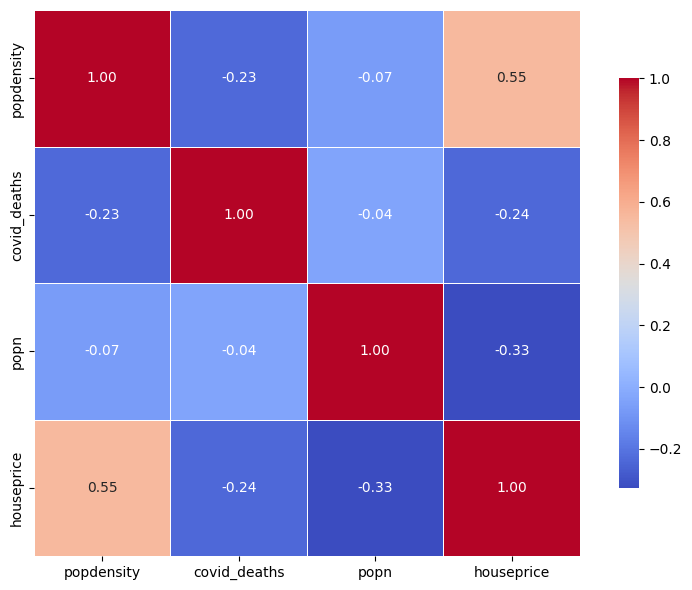

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# === Use only matched events ===
matched_events = joined[~joined["index_right"].isna()].copy()

# === Covariate columns ===
covariate_cols = ["popdensity", "covid_deaths", "popn", "houseprice"]

# === Compute correlation matrix ===
corr_matrix = matched_events[covariate_cols].corr(method='pearson')

# === Plot heatmap ===
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.75}
)
#plt.title("Covariate Correlation Matrix (Pearson)", fontsize=14)
plt.tight_layout()
plt.show()


#PCA on Covariates at Event Locations

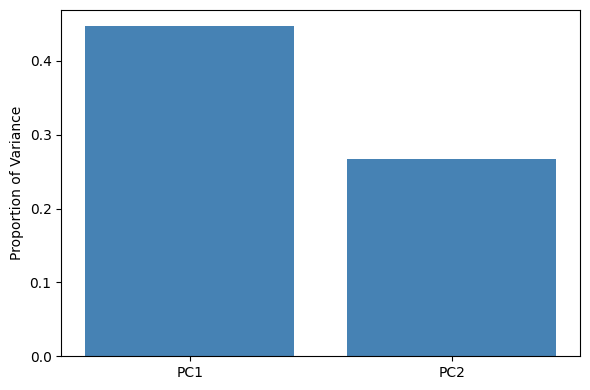

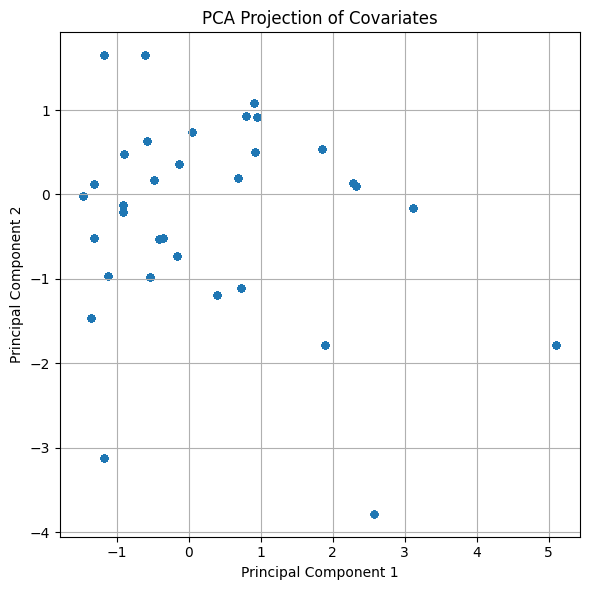

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt

# === Extract and scale covariates ===
covariate_cols = ["popdensity", "covid_deaths", "popn", "houseprice"]
X = matched_events[covariate_cols].dropna().copy()
X_scaled = StandardScaler().fit_transform(X)

# === Apply PCA ===
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# === Create DataFrame with PCA components ===
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])

# === Explained variance plot ===
plt.figure(figsize=(6, 4))
plt.bar(["PC1", "PC2"], pca.explained_variance_ratio_, color="steelblue")
#plt.title("Explained Variance by Principal Components")
plt.ylabel("Proportion of Variance")
plt.tight_layout()
plt.show()

# === Scatter plot of PCA projection ===
plt.figure(figsize=(6, 6))
plt.scatter(pca_df["PC1"], pca_df["PC2"], alpha=0.6, s=20)
plt.title("PCA Projection of Covariates")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()


#Combined Horizontal Plot: PC1 and PC2

In [ ]:
# === Add PC1 and PC2 to matched GeoDataFrame ===
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_gdf = matched_events.iloc[:len(pca_df)].copy()
pca_gdf["PC1"] = pca_df["PC1"].values
pca_gdf["PC2"] = pca_df["PC2"].values

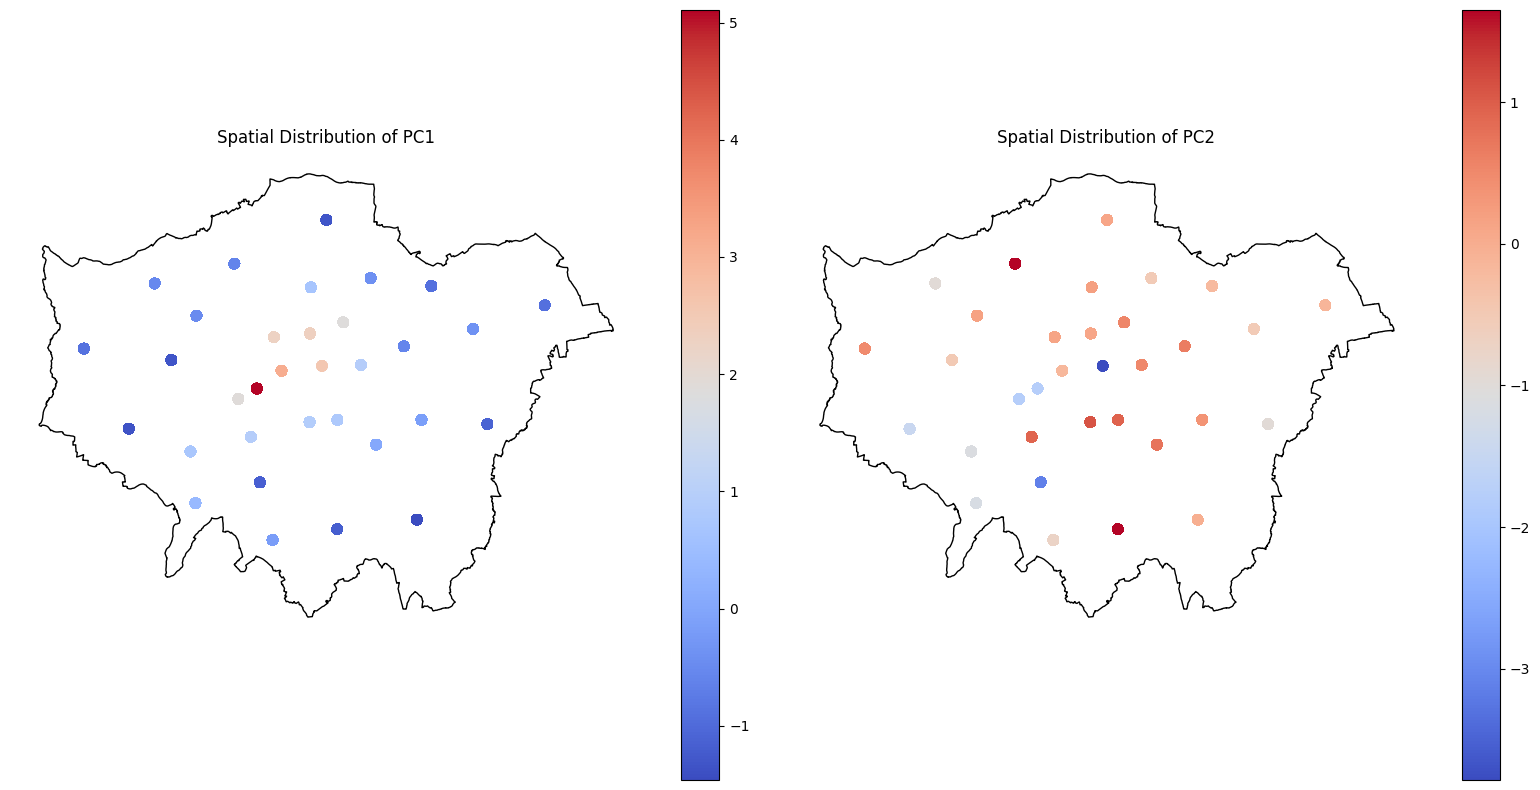

In [ ]:
from shapely.geometry import Point
import matplotlib.pyplot as plt

# === Ensure geometry and CRS are consistent ===
pca_gdf["geometry"] = matched_events.geometry.values
pca_gdf = gpd.GeoDataFrame(pca_gdf, geometry="geometry")

if pca_gdf.crs is None:
    pca_gdf.set_crs("EPSG:4326", inplace=True)

pca_gdf = pca_gdf.to_crs(shp.crs)

# === Create side-by-side plots for PC1 and PC2 ===
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# --- PC1 ---
shp.plot(ax=axs[0], color="white", edgecolor="black")
pca_gdf.plot(
    ax=axs[0],
    column="PC1",
    cmap="coolwarm",
    legend=True,
    markersize=50,
)
axs[0].set_title("Spatial Distribution of PC1")
axs[0].axis("off")

# --- PC2 ---
shp.plot(ax=axs[1], color="white", edgecolor="black")
pca_gdf.plot(
    ax=axs[1],
    column="PC2",
    cmap="coolwarm",
    legend=True,
    markersize=50,
)
axs[1].set_title("Spatial Distribution of PC2")
axs[1].axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# Loadings matrix
loadings = pd.DataFrame(
    pca.components_.T,
    columns=["PC1", "PC2"],
    index=covariate_cols
)

print("PCA Loadings (contributions of covariates to each PC):")
print(loadings.round(3))


PCA Loadings (contributions of covariates to each PC):
                PC1    PC2
popdensity    0.592  0.185
covid_deaths -0.362 -0.590
popn         -0.305  0.774
houseprice    0.652 -0.133


In [ ]:
from sklearn.cluster import KMeans

# Run K-means clustering on PCA coordinates
kmeans = KMeans(n_clusters=3, random_state=42)
pca_gdf["cluster"] = kmeans.fit_predict(pca_df[["PC1", "PC2"]])  # or directly: X_pca


In [ ]:
# If needed, convert to string for categorical plotting
pca_gdf["cluster"] = pca_gdf["cluster"].astype(str)


#Plot the Spatial Clusters

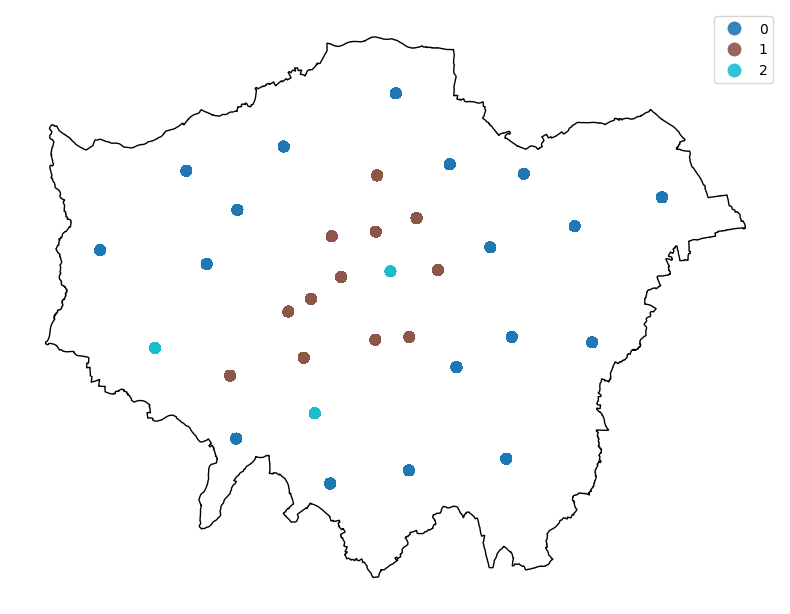

In [ ]:
# === Reuse the fixed geometry and CRS ===
pca_gdf["geometry"] = matched_events.geometry.values
pca_gdf = gpd.GeoDataFrame(pca_gdf, geometry="geometry")

# Ensure consistent CRS
if pca_gdf.crs is None:
    pca_gdf.set_crs("EPSG:4326", inplace=True)
pca_gdf = pca_gdf.to_crs(shp.crs)

# === Plot the KMeans Clusters ===
fig, ax = plt.subplots(figsize=(8, 10))
shp.plot(ax=ax, color="white", edgecolor="black")
pca_gdf.plot(
    ax=ax,
    column="cluster",
    categorical=True,
    cmap="tab10",
    legend=True,
    markersize=50,
    alpha=0.9
)
#plt.title("Spatial Clustering of PCA-Reduced Covariates", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()


<ipython-input-29-d2b1d56d867a>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("plasma")
<ipython-input-29-d2b1d56d867a>:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


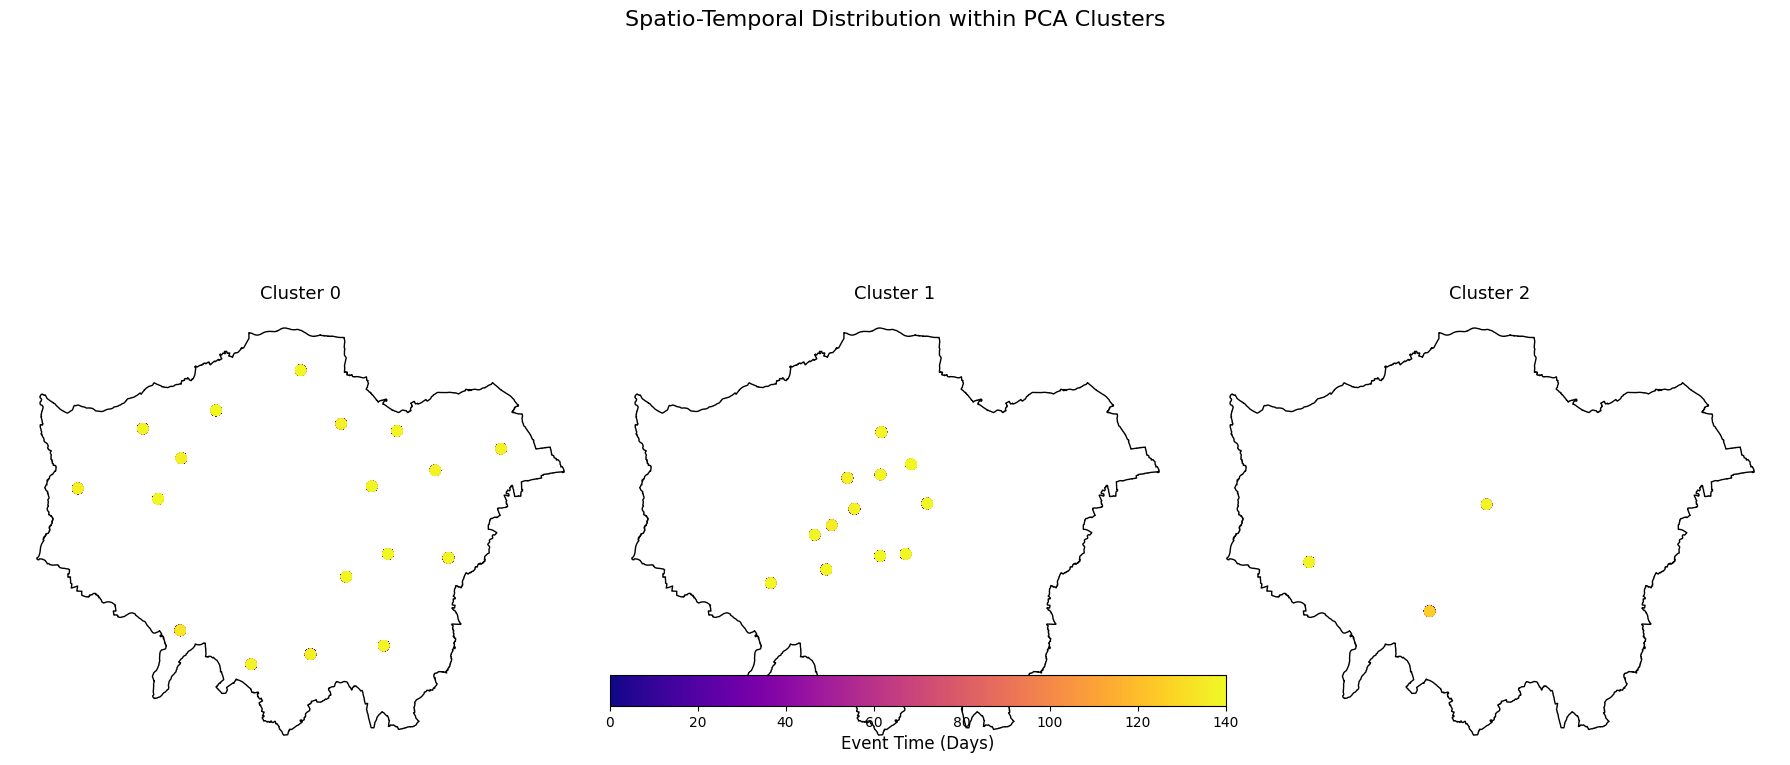

In [ ]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

# Set color scale for time
norm = Normalize(vmin=0, vmax=140)
cmap = cm.get_cmap("plasma")

# Plot each cluster separately, colored by time
unique_clusters = pca_gdf["cluster"].unique()
fig, axs = plt.subplots(1, len(unique_clusters), figsize=(6 * len(unique_clusters), 8), sharex=True, sharey=True)

for i, cl in enumerate(sorted(unique_clusters)):
    ax = axs[i] if len(unique_clusters) > 1 else axs
    subset = pca_gdf[pca_gdf["cluster"] == cl]

    shp.plot(ax=ax, color="white", edgecolor="black")
    subset.plot(
        ax=ax,
        column="T",
        cmap=cmap,
        norm=norm,
        markersize=50,
        alpha=0.9,
        legend=False
    )

    ax.set_title(f"Cluster {cl}", fontsize=13)
    ax.axis("off")

# Add shared colorbar for time
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm._A = []
cbar = fig.colorbar(sm, ax=axs, orientation="horizontal", fraction=0.05, pad=0.05)
cbar.set_label("Event Time (Days)", fontsize=12)

plt.suptitle("Spatio-Temporal Distribution within PCA Clusters", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [ ]:
summary_by_cluster = matched_events.copy()
summary_by_cluster["cluster"] = pca_gdf["cluster"].values
cluster_summary = summary_by_cluster.groupby("cluster")[covariate_cols].describe()
print(cluster_summary)


        popdensity                                                       \
             count          mean          std     min      25%      50%   
cluster                                                                   
0           6146.0   5306.013993  2028.434986  2214.0   4130.0   4764.0   
1           3235.0  12124.069861  2938.340689  3450.0  11045.0  12156.0   
2            619.0   5067.481422   468.978758  3361.0   4851.0   4851.0   

                          covid_deaths            ...      popn            \
             75%      max        count      mean  ...       75%       max   
cluster                                           ...                       
0         6154.0   9756.0       6146.0  0.611455  ...  341806.0  395869.0   
1        14758.0  16427.0       3235.0  0.143431  ...  324745.0  329677.0   
2         5490.0   5490.0        619.0  2.352181  ...  271523.0  271523.0   

        houseprice                                                    \
             c

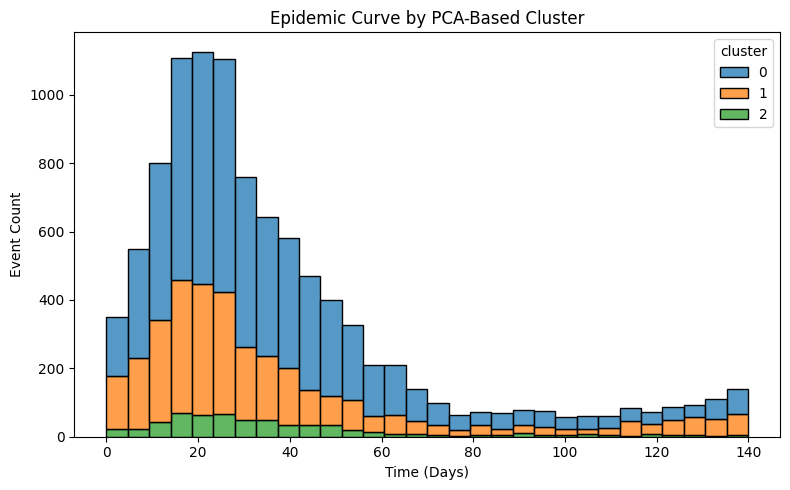

In [ ]:
import seaborn as sns
plt.figure(figsize=(8, 5))
sns.histplot(data=pca_gdf, x="T", hue="cluster", bins=30, multiple="stack")
plt.title("Epidemic Curve by PCA-Based Cluster")
plt.xlabel("Time (Days)")
plt.ylabel("Event Count")
plt.tight_layout()
plt.show()
